In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from new_aeb_gplvm import *
from utils.data_generator import DataGenerator
from utils.myutils import Utils
from tqdm import trange
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook
import json
import os
import pandas as pd
from sklearn.model_selection import train_test_split

import numpy as np
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
utils = Utils()
import time

2023-12-02 04:13:35.195994: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-02 04:13:35.234953: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
def create_dataframe(experiment):
    datagenerator = DataGenerator()

    noise_type = (
        None if experiment["noise_type"] == "normal" else experiment["anomaly_type"]
    )  # irrelevant,duplicated
    anomaly_type = (
        None if experiment["anomaly_type"] == "normal" else experiment["anomaly_type"]
    )  # cluster,global,local,dependency

    datagenerator.dataset = experiment["dataset"]
    data = datagenerator.generator(
        la=1.00,
        realistic_synthetic_mode=anomaly_type,
        noise_type=noise_type,
        noise_ratio=float(experiment["noise_ratio"]),
        stdscale=True,
        minmax=False,
    )

    Y_train = torch.tensor(data["X_train"], dtype=torch.float32)
    Y_test = torch.tensor(data["X_test"], dtype=torch.float32)
    lb_train = torch.tensor(data["y_train"], dtype=torch.float32)
    lb_test = torch.tensor(data["y_test"], dtype=torch.float32)

    return Y_train, Y_test, lb_train, lb_test

In [4]:
EXPERIMENTS_FILE = "experiments/refine/001_complete_normal_study.json"
with open(EXPERIMENTS_FILE) as file:
    experiments = json.load(file)

In [16]:
success_experiments = []
failed_experiments = []
for experiment in tqdm_notebook(experiments[:10]):
    Y_train, Y_test, lb_train, lb_test = create_dataframe(experiment)
    Y_val, Y_test, lb_val, lb_test = train_test_split(Y_test, lb_test, test_size=0.50, random_state=42)
    
    if experiment["anomaly_type"] == "normal" and experiment["noise_type"] == "normal":
        idx_n = np.where(lb_train == 0)[0]
        Y_train_normal = Y_train[idx_n]
        lb_train_normal = lb_train[idx_n]

    n_train = len(Y_train_normal)
    data_dim = Y_train_normal.shape[1]
    kernel = experiment["kernel"]
    latent_dim = int(experiment["latent_dim"])
    nn_layers = tuple(map(int, experiment["layers"].split(",")))
    n_inducing = int(experiment["n_inducing"])
    n_epochs = int(experiment["n_epochs"])
    lr = float(experiment["learning_rate"])
    batch_size = int(experiment["batch_size"])
    
    #print(experiment)

    try:
        gplvm = AD_GPLVM(
            latent_dim, n_inducing, n_epochs, nn_layers, lr, batch_size, kernel
        )

        # Fitting the Model
        train_start_time = time.time()
        gplvm.fit(Y_train_normal)
        train_end_time = time.time()

        # Validating the Model
        val = []
        for i in range(100):
            score = gplvm.predict_score(Y_val)
            val.append(score)
        validation_score = np.mean(val, axis=0)
        # validation_score = gplvm.calculate_train_elbo(Y_train_normal)

        # Results
        pred_start_time = time.time()
        test_score = gplvm.predict_score(Y_test)
        pred_end_time = time.time()

        # Save Metrics
        metrics = utils.metric(y_true=lb_val, y_score=validation_score)
        validation_metrics = utils.metric(y_true=lb_test, y_score=test_score)
        experiment["negative_elbo"] = validation_score.sum() #validation_score.sum()
        experiment["train_loss_curve"] = gplvm.loss_list
        experiment["val_auc_roc"] = validation_metrics["aucroc"]
        experiment["val_auc_pr"] = validation_metrics["aucpr"]
        experiment["test_auc_roc"] = metrics["aucroc"]
        experiment["test_auc_pr"] = metrics["aucpr"]
        experiment["training_time"] = train_end_time - train_start_time
        experiment["inference_time"] = pred_end_time - pred_start_time
        
        # Reconstrucao
        Y_val_recon, Y_val_recon_covar = gplvm.model.reconstruct_y(Y_val)
        experiment["val_reconstruct_error"] = float(utils.rmse(Y_val, Y_val_recon.T))

        utils.save_experiment(experiment)

    except Exception as error:
        print("An exception occurred:", error)
        experiment["test_auc_roc"] = 0.0
        experiment["test_auc_pr"] = 0.0
        utils.save_experiment(experiment)

/tmp/ipykernel_20270/157428504.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for experiment in tqdm_notebook(experiments[:10]):


  0%|          | 0/10 [00:00<?, ?it/s]

generating duplicate samples for dataset 29_Pima...


/home/jovyan/work/new_aeb_gplvm.py:319: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  klu_expanded = ll_shape.T.add_(klu).sum(-1).T.div((self.n_train))


generating duplicate samples for dataset 29_Pima...
generating duplicate samples for dataset 29_Pima...
generating duplicate samples for dataset 29_Pima...


KeyboardInterrupt: 

In [10]:
#pd.DataFrame(success_experiments).to_json("experiments/kernels/001_matern_rbf_all_results.json", orient="records")

In [11]:
#success_experiments

In [15]:
df_multi = pd.DataFrame(success_experiments)
df_multi.head(3)

,dataset,n_samples,n_features,n_anomaly,pct_anomaly,domain,kernel,batch_size,learning_rate,loss,...,auc_pr,training_time,inference_time,negative_elbo,train_loss_curve,val_auc_roc,val_auc_pr,test_auc_roc,test_auc_pr,val_reconstruct_error
0,29_Pima,768,8,268,34.9,Healthcare,rbf,128,0.01,normal,...,0.540259,5.984867,0.003297,11.981001,"[17.006107330322266, 16.415176391601562, 15.34...",0.681906,0.532201,0.743824,0.583026,0.916341
1,29_Pima,768,8,268,34.9,Healthcare,rbf,128,0.01,normal,...,0.550551,5.972720,0.003011,11.981757,"[17.004751205444336, 16.364700317382812, 15.25...",0.665316,0.522333,0.746353,0.585049,0.906031
2,29_Pima,768,8,268,34.9,Healthcare,rbf,128,0.01,normal,...,0.551247,7.484524,0.002489,11.925718,"[17.005996704101562, 16.36203384399414, 15.270...",0.630980,0.517767,0.749076,0.583925,0.843616


In [16]:
df_multi.columns

Index(['dataset', 'n_samples', 'n_features', 'n_anomaly', 'pct_anomaly',
       'domain', 'kernel', 'batch_size', 'learning_rate', 'loss',
       'anomaly_type', 'noise_type', 'noise_ratio', 'latent_dim', 'layers',
       'n_inducing', 'n_epochs', 'elbo', 'auc_roc', 'auc_pr', 'training_time',
       'inference_time', 'negative_elbo', 'train_loss_curve', 'val_auc_roc',
       'val_auc_pr', 'test_auc_roc', 'test_auc_pr', 'val_reconstruct_error'],
      dtype='object')

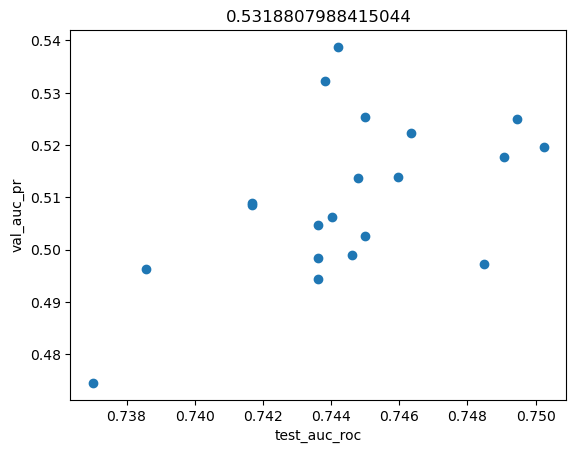

In [24]:
x, y ='test_auc_roc', 'val_auc_pr'
filter_df = df_multi.dataset == '29_Pima'
plt.scatter(df_multi[filter_df][x],df_multi[filter_df][y])
plt.xlabel(x)
plt.ylabel(y)
plt.title(pearsonr(df_multi[filter_df][x],df_multi[filter_df][y]).statistic)
None